In [61]:
# STANDARD LIBRARIES
import pandas as pd
import numpy as np
import pickle

# VISUALS
import matplotlib.pyplot as plt
import seaborn as sns

# FEATURE ENGINEERING AND PREPROCESSING
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors, NearestCentroid

# MODELING
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# METRICS
from sklearn.metrics import silhouette_score
import kneed
from kneed import knee_locator, KneeLocator

%matplotlib inline

# Read Files

In [3]:
main = pd.read_csv("../data/clean-data/main-engineered.csv", low_memory=False)
main.drop(columns="Unnamed: 0", inplace=True)

In [4]:
print(main.shape)
print(main.isna().sum().sum())
main.head()

(97515, 262)
0


,zipcode,lu_category,zip_street,zip_num_street,land_value,bldg_value,total_value,gross_tax_amount,total_a_prop,total_ah_prop,...,req_source_category_4_total_street,req_source_category_5_total_street,req_source_category_0_total_zip,req_source_category_1_total_zip,req_source_category_2_total_zip,req_source_category_3_total_zip,req_source_category_4_total_zip,req_source_category_5_total_zip,label_zip,label_street
0,2108,4,beacon 02108,87 beacon 02108,0,7842200,7842200,8265679,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,274
1,2108,6,beacon 02108,88 beacon 02108,0,12721500,12721500,13408461,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,274
2,2108,0,beacon 02108,89 beacon 02108,1373400,1588100,2961500,3121421,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,274
3,2108,6,beacon 02108,90 beacon 02108,0,7965700,7965700,8395849,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,274
4,2108,6,beacon 02108,91 beacon 02108,0,9757250,9757250,10284141,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,274


In [5]:
main["zipcode"].nunique()

34

In [6]:
Z = main.drop(columns=[
    "label_zip",
    "label_street",
    "zipcode",
    "zip_street",
    "zip_num_street"
])
X = main.drop(columns=[
    "label_zip",
    "label_street",
#     "st_name",
    "zipcode",
    "zip_street",
    "zip_num_street"
])
y = main["label_zip"]
# y = main["label_street"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

ss = StandardScaler()

Z = ss.fit_transform(X)
Z_train =  ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

# Distance

In [24]:
def nearest_nb(x):
    nb = NearestNeighbors(n_neighbors=5, algorithm="auto", metric="euclidean").fit(x)
    distances, indices = nb.kneighbors(x)
    
    return distances, indices
# https://stackoverflow.com/questions/51305370/calculating-average-distance-of-nearest-neighbours-in-pandas-dataframe

In [25]:
distances, indices = nearest_nb(Z)

In [26]:
#=========================
filename = "../assets/variables/main-nb-distances"
outfile = open(filename, "wb")
pickle.dump(distances, outfile)
outfile.close()

#=========================
filename = "../assets/variables/main-nb-indices"
outfile = open(filename, "wb")
pickle.dump(indices, outfile)
outfile.close()

In [42]:
#=========================
distances = pd.read_pickle("../assets/variables/main-nb-distances")

#=========================
indices = pd.read_pickle("../assets/variables/main-nb-indices")

In [43]:
distances.shape

(97515, 5)

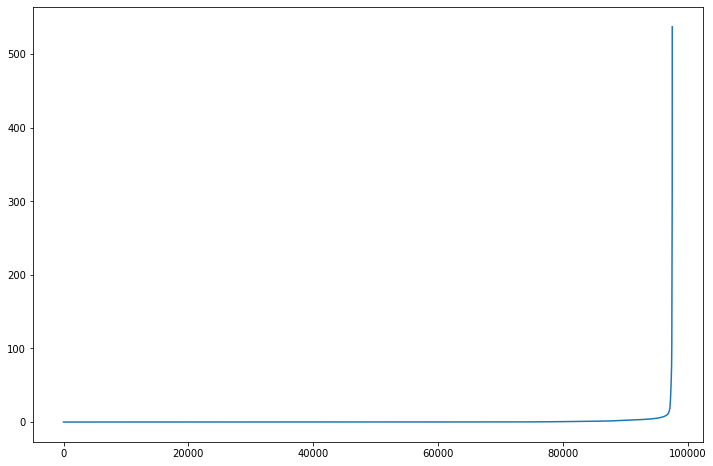

In [45]:
distances = np.sort(distances, axis=0)
# distances = distances[:, 1]

plt.figure(figsize=(12, 8))

plt.plot(distances)

0.8260038233215486


<Figure size 2160x1440 with 0 Axes>

<Figure size 360x360 with 0 Axes>

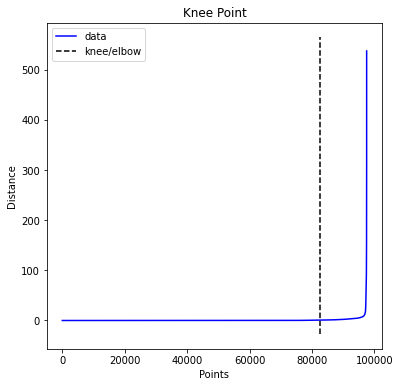

In [65]:
# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

# THIS PLOT SHOWS THE POINT OF MAX DISTANCE BETWEEN 2 POINTS
    # IT IS THE POINT OF 'GREATEST DEPARTURE'
plt.figure(figsize=(30, 20))

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [68]:
# SAVE THE MAX POINT FOR USE IN DBSCAN CLUSTERING
knee_point = distances[knee.knee]
knee_point

0.8260038233215486

# DBSCAN

**Limitations**

Implicit assumptions in this approach:

- Densities across all the clusters are the same.
- Cluster sizes or standard deviations are the same.

In [79]:
# RULE OF THUMB: min_samples SHOULD BE SET TO MIN NUM OF FEATURES
# https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

# Provide a value for epsilon which defines the maximum distance between two points
# Find a suitable value for epsilon by calculating the distance to 
    # the nearest n points for each point, sorting and plotting the results
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

dbscan = DBSCAN(eps=knee_point,
                min_samples=main.shape[1])
dbscan.fit(Z)

DBSCAN(algorithm='auto', eps=0.8260038233215486, leaf_size=30,
       metric='euclidean', metric_params=None, min_samples=262, n_jobs=None,
       p=None)

In [80]:
# The labels_ property contains the list of clusters and their respective points.
clusters = dbscan.labels_

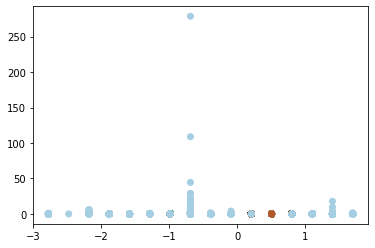

In [91]:
# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
# pred = dbscan.fit_predict(Z)
plt.scatter(Z[:,0], Z[:,1],c=pred, cmap="Paired")
# plt.title("DBSCAN")

In [92]:
clusters[clusters == -1].size

72345

In [85]:
silhouette_score(Z, clusters)

-0.17219833505520743

In [109]:
X["clusters"] = clusters
X["clusters"].value_counts(normalize=True)

-1     0.741886
 21    0.044444
 16    0.036118
 19    0.023227
 3     0.017720
 24    0.012398
 5     0.011567
 10    0.011444
 18    0.009465
 11    0.008624
 17    0.008358
 13    0.006984
 9     0.006584
 25    0.006348
 1     0.006327
 12    0.005127
 6     0.005127
 14    0.004943
 0     0.004584
 7     0.004287
 2     0.003907
 15    0.003640
 8     0.003569
 4     0.003569
 22    0.003487
 23    0.003333
 20    0.002933
Name: clusters, dtype: float64

In [110]:
X.loc[main["clusters"] == 0]

,lu_category,land_value,bldg_value,total_value,gross_tax_amount,total_a_prop,total_ah_prop,total_c_prop,total_cc_prop,total_cd_prop,...,req_source_category_3_total_street,req_source_category_4_total_street,req_source_category_5_total_street,req_source_category_0_total_zip,req_source_category_1_total_zip,req_source_category_2_total_zip,req_source_category_3_total_zip,req_source_category_4_total_zip,req_source_category_5_total_zip,clusters
6329,10,231300,701100,932400,982750,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6379,10,260400,603700,864100,910762,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6389,10,262500,338000,600500,632927,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6393,10,243700,496000,739700,779644,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6398,10,265200,805100,1070300,1128096,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9198,10,342600,850200,1192800,1257211,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9199,10,342500,1069900,1412400,1488670,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9205,10,327700,1052300,1380000,1454520,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9214,10,325100,934300,1259400,1327408,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [99]:
dbscan.components_

array([[ 0.20890938, -0.01182986, -0.01912911, ..., -0.05655065,
        -0.05383161, -0.05238041],
       [ 0.20890938, -0.01200628, -0.01994525, ..., -0.05655065,
        -0.05383161, -0.05238041],
       [ 0.20890938, -0.01177915, -0.01760291, ..., -0.05655065,
        -0.05383161, -0.05238041],
       ...,
       [ 0.20890938, -0.01231476, -0.01965805, ..., -0.05655065,
        -0.05383161, -0.05238041],
       [ 0.20890938, -0.01248695, -0.0206841 , ..., -0.05655065,
        -0.05383161, -0.05238041],
       [ 0.20890938, -0.01248378, -0.02079247, ..., -0.05655065,
        -0.05383161, -0.05238041]])

In [ ]:
#========================

In [81]:
def dbscan_plot(X, eps, min_samples):
    y_pred = dbscan.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
dbscan(Z, knee_point, main.shape[0])

In [51]:
colors = [
    'royalblue', 
    'maroon', 
    'forestgreen', 
    'mediumorchid', 
    'tan', 
    'deeppink', 
    'olive', 
    'goldenrod', 
    'lightcyan', 
    'navy'
]

# KMeans

**To help calculate an appropriate distance to model on, we will use `NearestNeighbors` to return the distances:**

# PCA

In [47]:
data_cols = pd.read_pickle("../assets/variables/data_cols")
pw_cols = pd.read_pickle("../assets/variables/pw_cols")
fire_cols = pd.read_pickle("../assets/variables/fire_cols")
requests_cols = pd.read_pickle("../assets/variables/requests_cols")

data_main_df = main[data_cols]
pw_main_df = main[pw_cols]
fire_main_df = main[fire_cols]
requests_main_df = main[requests_cols]

main_scaler = StandardScaler()
data_main_sc = main_scaler.fit_transform(data_main_df)
pw_main_sc = main_scaler.fit_transform(pw_main_df)
fire_main_sc = main_scaler.fit_transform(fire_main_df)
requests_main_sc = main_scaler.fit_transform(requests_main_df)

data_main_sc_df = pd.DataFrame(data_main_sc)
pw_main_sc_df = pd.DataFrame(pw_main_sc)
fire_main_sc_df = pd.DataFrame(fire_main_sc)
requests_main_sc_df = pd.DataFrame(requests_main_sc)

## Data Cols

In [60]:
pca_data = PCA(n_components=5,
          random_state=42)
pca_data.fit(data_main_sc_df)

var_exp = pca_data.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:20], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:20], 3)}")

Explained Variance (first 20 components): [0.387 0.18  0.096 0.07  0.06 ]

Cumulative Variance (first 20 components): [0.387 0.567 0.663 0.733 0.794]


## PW Violations Cols

In [58]:
pca_pw = PCA(n_components=5,
          random_state=42)
pca_pw.fit(pw_main_sc_df)

var_exp = pca_pw.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:20], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:20], 3)}")

Explained Variance (first 20 components): [0.276 0.128 0.09  0.073 0.063]

Cumulative Variance (first 20 components): [0.276 0.404 0.494 0.568 0.631]


## Fire Cols

In [62]:
pca_fire = PCA(n_components=3,
          random_state=42)
pca_fire.fit(fire_main_sc_df)

var_exp = pca_fire.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 5 components): {np.round(var_exp[:5], 3)}")
print("")
print(f"Cumulative Variance (first 5 components): {np.round(cum_var_exp[:5], 3)}")

Explained Variance (first 5 components): [0.442 0.243 0.199]

Cumulative Variance (first 5 components): [0.442 0.685 0.884]


## Requests Cols

In [63]:
pca_requests = PCA(n_components=5,
          random_state=42)
pca_requests.fit(requests_main_sc_df)

var_exp = pca_requests.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:20], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:20], 3)}")

Explained Variance (first 20 components): [0.503 0.125 0.054 0.048 0.041]

Cumulative Variance (first 20 components): [0.503 0.628 0.683 0.731 0.772]


## Entire Main DataFrame

In [111]:
# BASIC MOST MODEL
pca_main = PCA(n_components=5,
               random_state=42)
pca_main.fit(X_sc)

var_exp = pca_main.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:40], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:40], 3)}")

Explained Variance (first 20 components): [0.373 0.123 0.062 0.049 0.045]

Cumulative Variance (first 20 components): [0.373 0.495 0.557 0.606 0.651]


## For Supervised Learning Models

In [113]:
X = main.drop(columns="label")
y = main["label"]

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [115]:
ss = StandardScaler()
Z_train =  ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [116]:
pca_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("pca", PCA()),
    ("logreg", LogisticRegression())
])

In [118]:
pca_pipe.get_params();

In [124]:
params = {
    "pca__n_components": np.arange(1, 10, 1), # THERE ARE 118 COLUMNS
    "pca__random_state": [41],
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [0.01, 0.1, 1],
    "logreg__verbose": [100]
}

gs = GridSearchCV(
    pca_pipe,
    params,
    cv=5
)

In [120]:
Z_train

array([[-0.525148  , -0.19466292,  0.22358794, ..., -0.93738389,
        -0.90012905, -0.54744332],
       [-0.54675903, -0.38849968, -0.36165419, ..., -0.23583556,
         0.21829002, -0.54744332],
       [-0.42789837, -0.35706568, -0.50535326, ...,  0.37441538,
         0.22622207,  0.43013404],
       ...,
       [ 0.45815381, -0.60143096, -0.86313219, ..., -1.12958891,
        -0.99531365, -0.54744332],
       [-0.43870388, -0.03608859,  0.51004289, ...,  1.38349174,
         0.22622207, -0.54744332],
       [-0.25501014,  1.83146452,  2.3431829 , ...,  0.31675387,
         1.51518022, -0.54744332]])

In [123]:
gs.fit(Z_train, y_train)

ValueError: n_splits=5 cannot be greater than the number of members in each class.